# Prototype for false positive suppression function

In [35]:
import numpy as np
from scipy.signal import find_peaks, peak_widths
import seaborn as sns
import matplotlib.pyplot as plt

def fps(signal, min_height, max_height, ratio_range, max_distance, clean_distance):

    # Get positive and negative peaks
    pos_peak_ixs, pos_peak_props = find_peaks(signal, height=min_height)
    neg_peak_ixs, neg_peak_props = find_peaks(-signal, height=min_height)
    pos_peak_heights = pos_peak_props['peak_heights']
    neg_peak_heights = -neg_peak_props['peak_heights']

    # Combine and sort all peaks
    peak_ixs = np.hstack([pos_peak_ixs, neg_peak_ixs])
    peak_heights = np.hstack([pos_peak_heights, neg_peak_heights])
    sort_order = np.argsort(peak_ixs)
    peak_ixs = peak_ixs[sort_order]
    peak_heights = peak_heights[sort_order]

    # Compute distance and height ratio to next peak
    peak_dists = peak_ixs[1:] - peak_ixs[:-1]
    peak_ratios = peak_heights[:-1] / peak_heights[1:]

    # Peaks in distance
    dist_mask = peak_dists <= max_distance

    # Peak observes symmetry ratio
    ratio_mask = np.logical_and(peak_ratios < -1 + ratio_range, peak_ratios > -1 - ratio_range)

    # Flag peaks for deletion
    deletion_mask = np.logical_and(dist_mask, ratio_mask)

    # Append last tick
    deletion_mask = np.hstack([deletion_mask, False])

    # Remove transients within 'clean_distance' after each peak marked for deletion
    deleting = False # aux flag
    root_peak_ix = 0 # aux var to measure distance from peak marked for deletion
    for i, (mask_entry, peak_ix) in enumerate(zip(deletion_mask, peak_ixs)):
        if mask_entry and not deleting: # Just found a new root peak. We'll clean from this peak onwards
            deleting = True
            root_peak_ix = peak_ix
        elif deleting:
            dist_from_root = peak_ix - root_peak_ix
            if dist_from_root <= clean_distance: # If current peak is within range of last root peak, delete it
                deletion_mask[i] = True
            else: # we just moved past last peak's deletion range. let's see if curr peak is suitable for root
                if mask_entry:
                    root_peak_ix = peak_ix # yes it is
                else:
                    deleting = False # nope, leave this peak alone

    # Remove peaks higher than max height
    deletion_mask = np.logical_or(deletion_mask, np.abs(peak_heights) > max_height)

    # Clean signal and return relevant ixs
    peak_ixs = peak_ixs[np.logical_not(deletion_mask)]
    peak_heights = peak_heights[np.logical_not(deletion_mask)]

    return peak_ixs, peak_heights

**Plot sample signal**

<Figure size 432x288 with 0 Axes>

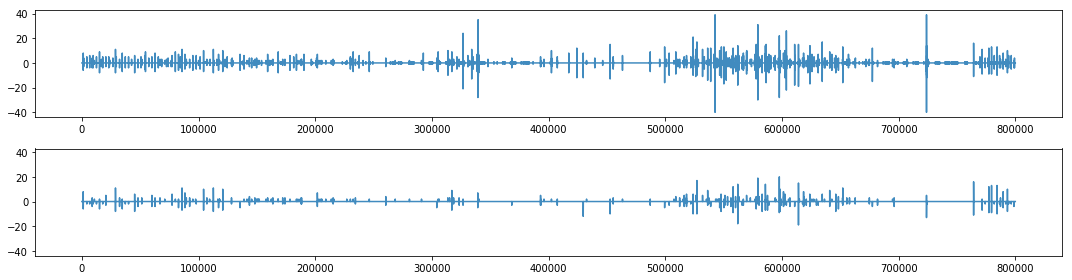

In [79]:
dir_list = [
        '../preprocessed_data/pp_train_db20/pp_train_db20_0.npy',
        '../preprocessed_data/pp_train_db20/pp_train_db20_1.npy',
        '../preprocessed_data/pp_train_db20/pp_train_db20_2.npy',
        '../preprocessed_data/pp_train_db20/pp_train_db20_3.npy',
        '../preprocessed_data/pp_train_db20/pp_train_db20_4.npy',
    ]
pp_signals = np.vstack([np.load(p) for p in dir_list])

# Selected signal
pp_signal = pp_signals[294, :]

plt.close('all')
plt.cla()
plt.clf()

# plot params
num_signals = 1

f, axs = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(15, 4))

for i in np.arange(0, num_signals):
    sampling_freq = 1
    t = np.arange(0, pp_signals.shape[1] / sampling_freq)
    axs[0].plot(t, pp_signal[::sampling_freq], alpha=0.85)
    clean_ixs, clean_heights = fps(
        signal=pp_signal,
        min_height=2,
        max_height=20,
        ratio_range=0.25,
        max_distance=10,
        clean_distance=500,
    )
    clean_signal = np.zeros(pp_signals.shape[1])
    clean_signal[clean_ixs] = clean_heights
    axs[1].plot(t, clean_signal, alpha=0.85)
    f.tight_layout()

In [86]:
# Get peak widths

cp_signal = np.copy(pp_signal)

(pos_clean_ixs, a, b) = clean_ixs[clean_heights >= 0]

pws = peak_widths(cp_signal, pos_clean_ixs)
pws[0].shape

ValueError: too many values to unpack (expected 3)

In [85]:
pos_clean_ixs.shape

(267,)

In [78]:
cp_signal[1184:1189]

array([100, 100,   8,  -6,   2], dtype=int8)

In [74]:
2**8

256